In [75]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd


In [76]:
dog_dir = './train/dogs'

# List all files in the directory
all_files = os.listdir(dog_dir)

# Create a list of images by reading each file in the directory
dog_images = [cv2.resize(cv2.imread(os.path.join(dog_dir, file)), (275, 275))
              for file in all_files if file.endswith(('.png', '.jpg', '.jpeg'))]

In [79]:
cat_dir = './train/cats'

# List all files in the directory
all_files = os.listdir(cat_dir)

cat_images = [cv2.resize(cv2.imread(os.path.join(cat_dir, file)), (275, 275))
              for file in all_files if file.endswith(('.png', '.jpg', '.jpeg'))]

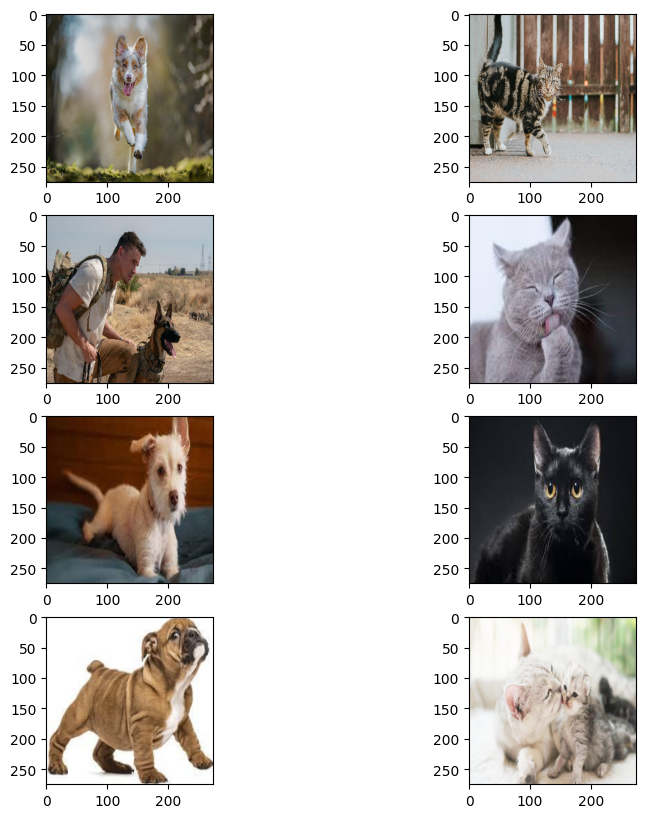

In [83]:
um_images = 8  # Limit to 8 images if more than 8 available
fig, ax = plt.subplots(4, 2, figsize=(10, 10))

for i, img in enumerate(dog_images[:4]):  # Display only first 4 dog images
    ax[i, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

for i, img in enumerate(cat_images[:4]):  # Display only first 4 cat images
    ax[i, 1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.show()